In [2]:
!pip install transformers datasets wordcloud nltk seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords
nltk.download('stopwords')

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Hyperparameters
vocab_size = 50257  # Using GPT-2 tokenizer vocab size
embed_size = 768
num_heads = 12
num_layers = 12
ff_hidden_size = 3072
max_seq_len = 128
batch_size = 60
learning_rate = 3e-4
num_epochs = 5
dropout = 0.1
sample_size = 300000

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_seq_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_len, embed_size)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [6]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_size % num_heads == 0
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.out = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        
        Q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_size)
        output = self.out(context)
        return output, attn

In [7]:
class FeedForward(nn.Module):
    def __init__(self, embed_size, ff_hidden_size):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_size, ff_hidden_size)
        self.fc2 = nn.Linear(ff_hidden_size, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

In [8]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, ff_hidden_size):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ffn = FeedForward(embed_size, ff_hidden_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output, attn_weights = self.self_attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x, attn_weights

In [9]:
class GPT2(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, num_heads, ff_hidden_size, max_seq_len):
        super(GPT2, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoding = PositionalEncoding(embed_size, max_seq_len)
        self.dropout = nn.Dropout(dropout)
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(embed_size, num_heads, ff_hidden_size)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(embed_size, vocab_size)
        
    def create_mask(self, seq_len):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        return ~mask

    def forward(self, x):
        batch_size, seq_len = x.size()
        x = self.token_embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        mask = self.create_mask(seq_len).to(x.device)
        attentions = []
        for layer in self.decoder_layers:
            x, attn_weights = layer(x, mask)
            attentions.append(attn_weights)
        
        logits = self.output_layer(x)
        return logits, attentions


In [10]:
class TinyStoriesDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        return input_ids

In [11]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/tinystories-narrative-classification/train.csv')
val_df = pd.read_csv('/kaggle/input/tinystories-narrative-classification/validation.csv')

# Ensure the 'text' column contains only valid strings
def clean_text_column(df):
    df = df.dropna(subset=['text'])  # Drop rows where 'text' is NaN
    df['text'] = df['text'].astype(str)  # Convert all entries in 'text' to strings
    return df

train_df = clean_text_column(train_df)
train_df = train_df.sample(n=sample_size, random_state=42).reset_index(drop=True)
val_df = clean_text_column(val_df)

print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Create datasets and dataloaders
train_dataset = TinyStoriesDataset(train_df, tokenizer, max_seq_len)
val_dataset = TinyStoriesDataset(val_df, tokenizer, max_seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model
model = GPT2(vocab_size, embed_size, num_layers, num_heads, ff_hidden_size, max_seq_len).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        inputs = batch[:, :-1].to(device)  # Input tokens
        targets = batch[:, 1:].to(device)  # Target tokens (shifted by one position)
        
        optimizer.zero_grad()
        logits, _ = model(inputs)
        loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 1000 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')


/tmp/ipykernel_35/2523955166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)  # Convert all entries in 'text' to strings


Number of training samples: 300000
Number of validation samples: 21990


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Epoch 1, Batch 0, Loss: 11.0527
Epoch 1, Batch 1000, Loss: 5.7395
Epoch 1, Batch 2000, Loss: 5.7869
Epoch 1, Batch 3000, Loss: 5.6958
Epoch 1, Batch 4000, Loss: 5.6957
Epoch 1, Average Loss: 5.7470
Epoch 2, Batch 0, Loss: 5.6773
Epoch 2, Batch 1000, Loss: 5.7745
Epoch 2, Batch 2000, Loss: 5.6641
Epoch 2, Batch 3000, Loss: 5.6856
Epoch 2, Batch 4000, Loss: 5.6459
Epoch 2, Average Loss: 5.6889
Epoch 3, Batch 0, Loss: 5.7091
Epoch 3, Batch 1000, Loss: 5.5853
Epoch 3, Batch 2000, Loss: 5.6254
Epoch 3, Batch 3000, Loss: 5.6856
Epoch 3, Batch 4000, Loss: 5.7261
Epoch 3, Average Loss: 5.6795
Epoch 4, Batch 0, Loss: 5.7522
Epoch 4, Batch 1000, Loss: 5.6398
Epoch 4, Batch 2000, Loss: 5.7307
Epoch 4, Batch 3000, Loss: 5.6700
Epoch 4, Batch 4000, Loss: 5.6389
Epoch 4, Average Loss: 5.6747
Epoch 5, Batch 0, Loss: 5.7243
Epoch 5, Batch 1000, Loss: 5.6739
Epoch 5, Batch 2000, Loss: 5.6891
Epoch 5, Batch 3000, Loss: 5.7044
Epoch 5, Batch 4000, Loss: 5.6835
Epoch 5, Average Loss: 5.6708


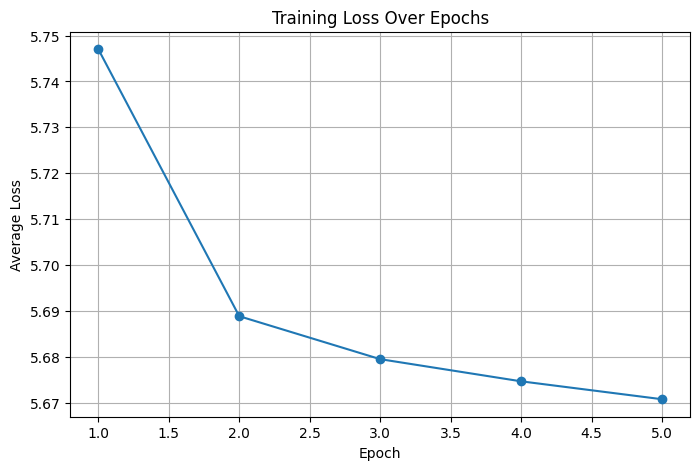

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [ ]:
# Set device to CPU explicitly
device = torch.device('cpu')

# Move your model to CPU
model.to(device)

def compute_perplexity(model, dataloader, vocab_size, device):
    model.eval()
    total_loss = 0
    total_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing Perplexity"):
            inputs = batch.to(device)             # Move inputs to CPU
            targets = inputs.clone()              # next-token prediction

            logits, _ = model(inputs)             # Forward pass on CPU
            loss = criterion(logits.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()
            total_batches += 1

    avg_loss = total_loss / total_batches
    perplexity = math.exp(avg_loss)
    return perplexity

# Call compute_perplexity with device='cpu'
train_perplexity = compute_perplexity(model, train_loader, vocab_size, device)
val_perplexity = compute_perplexity(model, val_loader, vocab_size, device)

print(f"Train Perplexity: {train_perplexity:.2f}")
print(f"Validation Perplexity: {val_perplexity:.2f}")


In [ ]:
def plot_perplexity(train_perplexities, val_perplexities):
    epochs = range(1, len(train_perplexities) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_perplexities, label='Train Perplexity', marker='o')
    plt.plot(epochs, val_perplexities, label='Validation Perplexity', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Perplexity over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
def generate_text(model, tokenizer, prompt, max_len=50, device='cuda', temperature=1.0):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    for _ in range(max_len):
        outputs, _ = model(input_ids)
        next_token_logits = outputs[:, -1, :] / temperature  # Apply temperature
        
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
        
        input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return generated_text
    
prompt = "Once upon "
generated_text = generate_text(model, tokenizer, prompt, max_len=50, device=device)
print(f"Generated Text: {generated_text}")


Generated Text: Once upon  there upon was upon upon upon upon day upon upon upon upon uponia upon upon uponily upon upon upon upon upon upon upon upon upon there upon upon upon upon upon a upon upon upon there upon upon upon and upon upon upon upon day and day upon


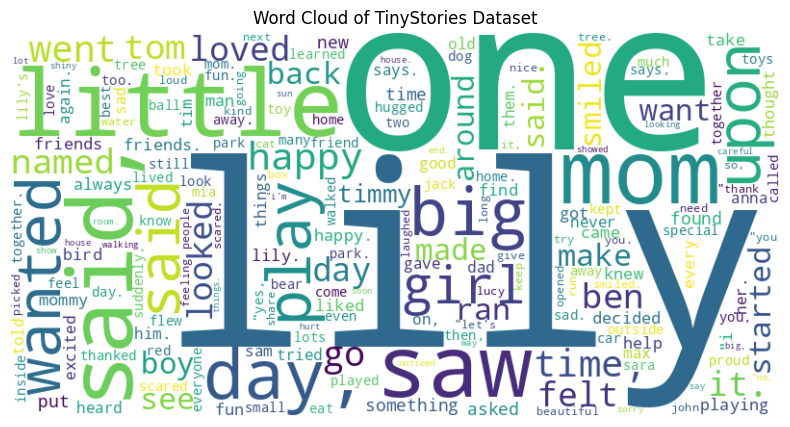

In [35]:
def plot_word_cloud(data, sample_size):
    sampled_data = data.sample(n=min(sample_size, len(data)), random_state=42)
    all_text = " ".join(sampled_data["text"])
    stop_words = set(stopwords.words('english')).union(STOPWORDS)
    words = [word.lower() for word in all_text.split() if word.lower() not in stop_words]
    word_freq = Counter(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of TinyStories Dataset')
    plt.show()

plot_word_cloud(train_df, sample_size)


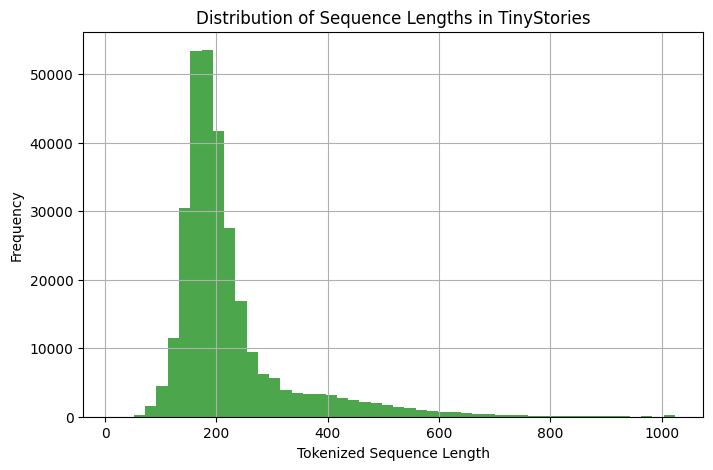

In [37]:
def plot_token_length_distribution(data, tokenizer):
    sampled_data = data.sample(n=min(sample_size, len(data)), random_state=42)
    sequence_lengths = [len(tokenizer.encode(text, truncation=True)) for text in sampled_data["text"]]
    
    plt.figure(figsize=(8, 5))
    plt.hist(sequence_lengths, bins=50, color='green', alpha=0.7)
    plt.xlabel('Tokenized Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sequence Lengths in TinyStories')
    plt.grid(True)
    plt.show()

plot_token_length_distribution(train_df, tokenizer)


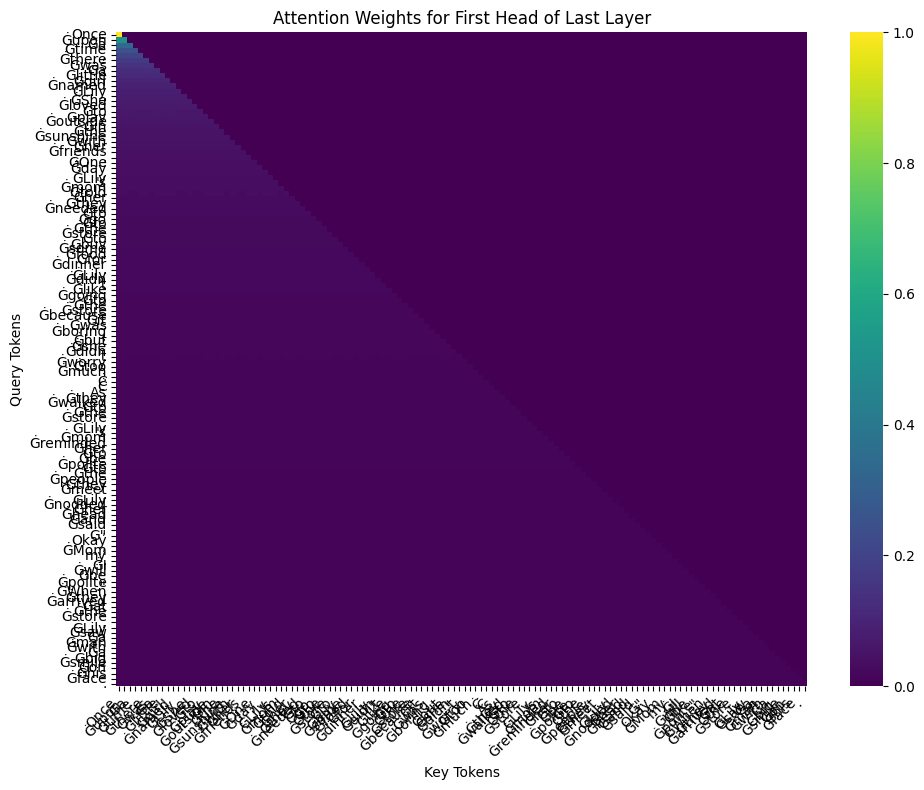

In [36]:
def plot_attention_heatmap(model, tokenizer, text, device):
    model.eval()
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).input_ids.to(device)
    with torch.no_grad():
        logits, attentions = model(input_ids)
    attention = attentions[-1][0, 0, :, :].detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title('Attention Weights for First Head of Last Layer')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

sample_text = train_df.iloc[0]['text']
plot_attention_heatmap(model, tokenizer, sample_text, device)


In [51]:
# Save model
torch.save(model.state_dict(), 'gpt2_tinystories.pth')
print("Model weights saved as 'gpt2_tinystories.pth'")

Model weights saved as 'gpt2_tinystories.pth'
